In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH = 12
WIDTH = 0.25  # the width of the bars
NARROW = 0.2
XLINE  = 523.21
YLINE  = 0.002
colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

In [224]:
def get_joined_data():
    """Returns single (joined) dataframe"""
    
    # Combining V100 and P100 on same row for same run
    # We are deleting cases where there is no run for either of the architectures
    # Every column name is appended with the name of the architecture (e.g. "_V100");
    # This includes the `master_index` (e.g `master_index_V100`)

    df_joined = pd.read_parquet('../df_master_joined.parquet')
    df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
    df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
    
    return df_joined

def filter_lt_val(df, val=1e9):
    ##temp_col = df['dram_write_throughput_V100'] + df['dram_read_throughput_V100']
    #temp_col3 = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
    #temp_col = df['dram_write_throughput_P100']
    #temp_col2 = df['dram_read_throughput_P100']
    #temp_col4 = df['dram_write_throughput_V100']
    temp_col5 = df['dram_read_throughput_V100'] ## trouble predicting read throughput
    #df =df[temp_col>val]
    #df =df[temp_col2>val]
    #df =df[temp_col4>=val]
    df =df[temp_col5>=val]
    #df_joined = df_joined[temp_col3>1e9]
    #return df[temp_col > val]
    return df

_columns = None
def get_columns():
    global _columns
    # This is an "empty" dataframe (meaning no rows), containing
    # column names for numerical data only.
    # The column nmaes can be used to index the columns of the
    # scaled data (in master_scaled_data.npy)
    if _columns is None:
        _columns = tuple(pd.read_parquet('../df_column_reference.parquet').columns)
    return _columns


_scaled_data = None
def get_scaled_data(row_index):
    global _scaled_data
    # This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
    # The data has been scaled using the StandardScaler in scikitlearn

    # Notes: 
    #   - The row indices correspond to the `master_index` column of 'df_master.parquet'
    #   - The columns correspond to the columns in 'df_column_reference.parquet'.
    #     (e.g. can use `df.get_loc(column-name)` to get the column index)

    if _scaled_data is None:
        _scaled_data = np.load('../master_scaled_data.npy')
    return _scaled_data[row_index]

def get_data(filter_val=10e9):
    """Returns full data and target vector"""
    
    df = get_joined_data()  # Start with all of df_joined
    
    df = filter_lt_val(df, filter_val)  # Filter throughput < 1e9
    
    # Training data index and values (values ARE in master_data_scaled)
    data_row_index = df['master_index_P100'].values
    data = get_scaled_data(data_row_index)
    col_indices = []
    for i, col in enumerate(get_columns()):
        if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
            col_indices.append(i)
    data = data[:, col_indices]

    #target_row_index = df['master_index_V100'].values
    #target = get_scaled_data(target_row_index)      
    #target_col_indices = []
    #for i, col in enumerate(get_columns()):
    #    if col in ['dram_read_throughput', 'dram_write_throughput']:
    #        target_col_indices.append(i)
    #target = target[:, target_col_indices[0]] + target[:, target_col_indices[1]]
    ref = (df['dram_read_throughput_V100']).values #+ df['dram_write_throughput_V100']).values
    scaler = StandardScaler()
    scaler.fit(ref.reshape(-1, 1))
    target = scaler.transform(ref.reshape(-1, 1)).reshape(ref.shape)

    return data, target, scaler

In [225]:
data, target, scaler = get_data(filter_val=1e9)

# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
) = train_test_split(
    data,
    target,
    random_state=42,
    test_size=.33
)

In [226]:
data.shape

(18426, 112)

In [227]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

In [228]:
y_test_predict = clf.predict(X_test)
errors = abs(y_test_predict - y_test)

In [229]:
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:", mean_absolute_percentage_error(y_test, y_test_predict))

Mean Absolute Error: 0.08
Mean absolute percentage error: 0.2965795736045991


In [230]:
y_test_bytes =  scaler.inverse_transform(y_test)/1e9
y_test_predict_bytes =  scaler.inverse_transform(y_test_predict)/1e9
errors = abs(y_test_predict_bytes - y_test_bytes)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:", mean_absolute_percentage_error(y_test_bytes, y_test_predict_bytes))

Mean Absolute Error: 10.71
Mean absolute percentage error: 0.25553293329980686


Text(0,0.5,'Predicted')

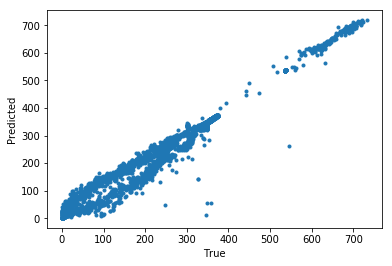

In [231]:
plt.plot(y_test_bytes, y_test_predict_bytes,'.')
plt.xlabel('True')
plt.ylabel('Predicted')

In [232]:
np.mean(errors)/np.mean(y_test_bytes)

0.03895942700420391

In [233]:
min(y_test_bytes)

1.0177730314240112

In [234]:
max(y_test_bytes)

731.767937957888